# Gradient Boosting with XGBoost



We illustrate the following regression method on a data set called "Hitters", which includes 20 variables and 322 observations of major league baseball players. The goal is to predict a baseball player’s salary on the basis of various features associated with performance in the previous year. We don't cover the topic of exploratory data analysis in this notebook. 

- Visit [this documentation](https://cran.r-project.org/web/packages/ISLR/ISLR.pdf) if you want to learn more about the data

## Setup

In [67]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
print("XGB Version:", xgb.__version__)

from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

XGB Version: 1.6.0


## Data

- See [](hitters_data.ipynb) for details about the data preprocessing steps.
- We simply import the preprocessed data by using this [Python script](https://github.com/kirenz/regression/blob/main/docs/hitters_data.py) which will yield:
  - X_train, X_test, y_train, y_test
  - df_train and df_tests
  - feature_names

In [50]:
from hitters_data import *

## Model

- Define hyperparameters

In [52]:
params = {
    "n_estimators":500,
    "max_depth": 4,
    "learning_rate": 0.01,
    "eval_metric": "rmse"
}

- Prepare evaulation data

In [51]:
eval_set = [(X_train, y_train), (X_test, y_test)]

- Build and fit model

In [53]:
reg = xgb.XGBRegressor(**params)

reg.fit(X_train, y_train, eval_set=eval_set)

[0]	validation_0-rmse:693.13939	validation_1-rmse:694.51649
[1]	validation_0-rmse:687.25191	validation_1-rmse:688.37644
[2]	validation_0-rmse:681.42445	validation_1-rmse:682.31515
[3]	validation_0-rmse:675.64867	validation_1-rmse:677.35826
[4]	validation_0-rmse:669.93320	validation_1-rmse:672.46290
[5]	validation_0-rmse:664.27350	validation_1-rmse:666.60591
[6]	validation_0-rmse:658.67121	validation_1-rmse:661.82838
[7]	validation_0-rmse:653.12688	validation_1-rmse:656.90319
[8]	validation_0-rmse:647.63961	validation_1-rmse:652.24138
[9]	validation_0-rmse:642.19390	validation_1-rmse:646.64970
[10]	validation_0-rmse:636.80992	validation_1-rmse:641.92285
[11]	validation_0-rmse:631.48134	validation_1-rmse:637.27762
[12]	validation_0-rmse:626.19614	validation_1-rmse:631.90670
[13]	validation_0-rmse:620.97255	validation_1-rmse:627.37414
[14]	validation_0-rmse:615.80413	validation_1-rmse:622.82286
[15]	validation_0-rmse:610.68529	validation_1-rmse:618.45032
[16]	validation_0-rmse:605.60407	v

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

- Make predictions

In [63]:
y_pred = reg.predict(X_test)

- Obtain RMSE

In [66]:
mean_squared_error(y_test, y_pred, squared = False)

305.34809490903564

- Save te model

In [65]:
# Save model into JSON format.
reg.save_model("regressor.json")

### Plot training test deviance


- Obtain evaluation metrics

In [57]:
results = reg.evals_result()

In [ ]:
- Plot 

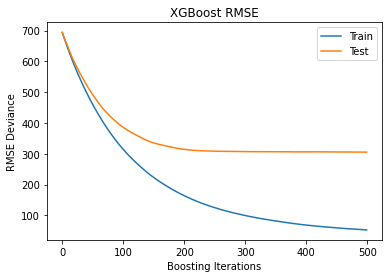

In [58]:
# Prepare x-axis
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# Make plot
fig, ax = plt.subplots()

ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
#ax.legend()

plt.title('XGBoost RMSE')
plt.xlabel("Boosting Iterations")
plt.ylabel("RMSE Deviance")
plt.legend(loc="upper right");


## Feature importance

- Next, we take a look at the tree based feature importance and the permutation importance.

### Mean decrease in impurity (MDI)

- Mean decrease in impurity (MDI) is a measure of feature importance for decision tree models.

- They are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

- Note that impurity-based importances are computed on training set statistics and therefore do not reflect the ability of feature to be useful to make predictions that generalize to the test set (when the model has enough capacity).

- Also note that impurity-based importances are biased towards high cardinality features (i.e., features with many unique values). See Permutation feature importance as an alternative below.

- Feature importances are provided by the function `plot_importance` 

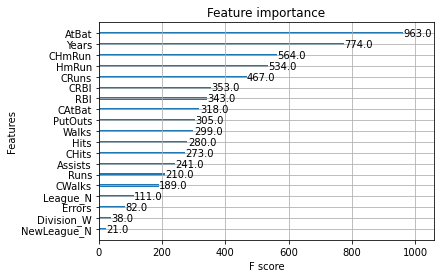

In [59]:
xgb.plot_importance(reg);



#### Permutation feature importance

- Permutation feature importance overcomes limitations of the impurity-based feature importance ([scikit learn](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)): 
  - they do not have a bias toward high-cardinality features
  - they can be computed on a left-out test set.

It is a model inspection technique that can be used for any fitted estimator when the data is tabular (see [scikit learn](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance) for more details):

- The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. 
- This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. 
- This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature.
- The permutation importance is calculated on the training set to show how much the model relies on each feature during training.

- Features are shuffled n times and the model refitted to estimate the importance of it. 


Note however that when two features are correlated and one of the features is permuted, the model will still have access to the feature through its correlated feature. This will result in a lower importance value for both features, where they might actually be important. One way to handle this is to cluster features that are correlated and only keep one feature from each cluster. This strategy is explored in this example: [Permutation Importance with Multicollinear or Correlated Features](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#handling-multicollinear-features).

In [60]:
result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

tree_importances = pd.Series(result.importances_mean, index=feature_names)

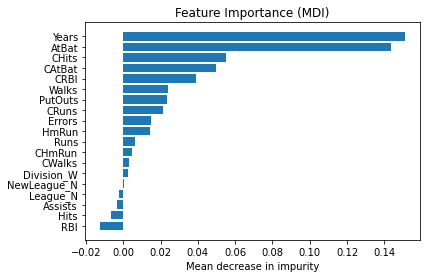

In [61]:
# sort features according to importance
sorted_idx = np.argsort(tree_importances)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, tree_importances[sorted_idx], align="center")

plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");

- Same data plotted as boxplot:

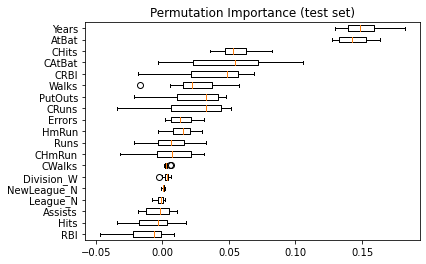

In [62]:
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names)[sorted_idx],
)

plt.title("Permutation Importance (test set)")
plt.show()

- We observe that the same features are detected as most important using both methods. Although the relative importances vary (especially for feature `Years`).